In [1]:
from dctkit.dec import cochain as C
from dctkit.mesh.simplex import SimplicialComplex
from dctkit.mesh.util import generate_1_D_mesh
from dctkit.math.opt import optctrl as oc
import matplotlib.pyplot as plt
from deap import gp
from alpine.gp import gpsymbreg as gps
from alpine.gp import primitives
from dctkit import config
import dctkit
import networkx as nx
from ray.util.multiprocessing import Pool
import ray
import numpy as np
import math
import yaml
from typing import Tuple, Callable
import numpy.typing as npt

In [2]:
# choose precision and whether to use GPU or CPU
# needed for context of the plots at the end of the evolution
config()

def eval_MSE(residual: Callable, indlen: int, X: npt.NDArray, y: npt.NDArray,
             S: SimplicialComplex, u_0: C.CochainP0, return_best_sol: bool = False) -> float:

    num_nodes = X.shape[1]

    # need to call config again before using JAX in energy evaluations to make sure that
    # the current worker has initialized JAX
    config()

    # objective: squared norm of the residual of the equation + penalty on Dirichlet 
    # boundary condition on the first node
    def obj(x, y):
        penalty = 100.*x[0]**2
        u = C.CochainP0(S, x)
        f = C.CochainP0(S, y)
        r = residual(u, f)
        total_energy = C.inner_product(r, r) + penalty
        return total_energy

    prb = oc.OptimizationProblem(dim=num_nodes, state_dim=num_nodes, objfun=obj)

    total_err = 0.

    best_sols = []

    for i, vec_y in enumerate(y):
        # set additional arguments of the objective function (apart from the vector of unknowns)
        args = {'y': vec_y}
        prb.set_obj_args(args)

        # minimize the objective
        x = prb.run(x0=u_0.coeffs, ftol_abs=1e-12, ftol_rel=1e-12, maxeval=1000)

        if (prb.last_opt_result == 1 or prb.last_opt_result == 3
                or prb.last_opt_result == 4):

            current_err = np.linalg.norm(x-X[i, :])**2
        else:
            current_err = math.nan

        if math.isnan(current_err):
            total_err = 1e5
            break

        total_err += current_err

        best_sols.append(x)

    if return_best_sol:
        return best_sols

    total_err *= 1/X.shape[0]

    return total_err

In [3]:
@ray.remote
def eval_fitness(individual: Callable, indlen: int, X: npt.NDArray, y: npt.NDArray,
                 S: SimplicialComplex, u_0: C.CochainP0, penalty: dict) -> Tuple[float, ]:

    objval = 0.

    total_err = eval_MSE(individual, indlen, X, y, S, u_0)

    # add penalty on length of the tree to promote simpler solutions
    objval = total_err + penalty["reg_param"]*indlen

    return objval,

In [4]:
def stgp_poisson():
    with open("ex1.yaml") as config_file:
        config_file_data = yaml.safe_load(config_file)

    # generate mesh and dataset
    S_1, x = generate_1_D_mesh(num_nodes=11, L=1.)
    S = SimplicialComplex(S_1, x, is_well_centered=True)
    S.get_circumcenters()
    S.get_primal_volumes()
    S.get_dual_volumes()
    S.get_hodge_star()
    num_nodes = S.num_nodes

    # generate training and test datasets
    # exact solution = x² 
    u = C.CochainP0(S, np.array(x[:,0]**2, dtype=dctkit.float_dtype))
    # compute source term such that u solves the discrete Poisson equation 
    # Delta u + f = 0, where Delta is the discrete Laplace-de Rham operator
    f = C.laplacian(u)
    f.coeffs *= -1.
    X_train = np.array([u.coeffs],dtype=dctkit.float_dtype)
    y_train = np.array([f.coeffs], dtype=dctkit.float_dtype)

    # initial guess for the unknown of the Poisson problem (cochain of nodals values)
    u_0_vec = np.zeros(num_nodes, dtype=dctkit.float_dtype)
    u_0 = C.CochainP0(S, u_0_vec)

    # define primitive set for the residual of the discrete Poisson equation
    pset = gp.PrimitiveSetTyped("RESIDUAL", [C.CochainP0, C.CochainP0], C.CochainP0)

    # rename arguments of the residual
    pset.renameArguments(ARG0="u")
    pset.renameArguments(ARG1="f")

    # set parameters of the symbolic regression problem from config file
    # also create toolbox needed for Genetic Programming algorithm
    GPproblem_settings, GPproblem_run, GPproblem_extra = gps.load_config_data(
        config_file_data=config_file_data, pset=pset)
    toolbox = GPproblem_settings['toolbox']
    penalty = GPproblem_extra['penalty']

    # add primitives to the primitive set, as specified in the config file
    primitives.addPrimitivesToPset(pset, GPproblem_settings['primitives'])

    GPproblem_settings.pop('primitives')

    ray.init()

    # store shared objects refs
    S_ref = ray.put(S)
    u_0_ref = ray.put(u_0)
    penalty_ref = ray.put(penalty)
    X_train_ref = ray.put(X_train)
    y_train_ref = ray.put(y_train)

    # set arguments for evaluate functions
    args_train = {'X': X_train_ref, 'y': y_train_ref, 'S': S_ref, 'u_0': u_0_ref, 
                  'penalty': penalty_ref}

    # register functions for fitness/MSE evaluation on different datasets
    toolbox.register("evaluate_train", eval_fitness.remote, **args_train)

    # create symbolic regression problem instance
    GPproblem = gps.GPSymbRegProblem(pset=pset, **GPproblem_settings)

    # MULTIPROCESSING MAP FUNCTION-------------------------------------------------------
    pool = Pool()

    def ray_mapper(f, individuals, toolbox):
        # We are not duplicating global scope on workers so we need to use the toolbox
        # Transform the tree expression in a callable function
        runnables = [toolbox.compile(expr=ind) for ind in individuals]
        lenghts = [len(ind) for ind in individuals]
        fitnesses = ray.get([f(*args) for args in zip(runnables, lenghts)])
        return fitnesses

    GPproblem.toolbox.register("map", ray_mapper, toolbox=GPproblem.toolbox)
    # ----------------------------------------------------------------------------------

    GPproblem.run(plot_history=False, print_log=True, seed=None, **GPproblem_run)

    best = GPproblem.best

    # compute the solution corresponding to the best individual
    u_best = eval_MSE(GPproblem.toolbox.compile(expr=best), len(str(best)),
                          X_train, y_train, S=S, u_0=u_0, return_best_sol=True)[0]

    pool.close()
    ray.shutdown()

    plt.figure()
    plt.plot(x[:,0], u.coeffs)
    plt.plot(x[:,0], u_best, "ro")
    plt.show()

    # plot the tree of the best individual
    nodes, edges, labels = gp.graph(best)
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    pos = nx.nx_agraph.graphviz_layout(graph, prog="dot")
    plt.figure(figsize=(7, 7))
    nx.draw_networkx_nodes(graph, pos, node_size=900, node_color="w")
    nx.draw_networkx_edges(graph, pos)
    nx.draw_networkx_labels(graph, pos, labels)
    plt.axis("off")
    plt.show()


2023-06-01 15:45:14,883	INFO worker.py:1625 -- Started a local Ray instance.


> MODEL TRAINING/SELECTION STARTED
Generating initial population...
 -= START OF EVOLUTION =- 
Evaluating initial population...
DONE.
   	     	           fitness           	             size             
   	     	-----------------------------	------------------------------
gen	evals	min   	avg   	max   	std  	min	avg 	max	std   
1  	100  	2.8333	2.9527	3.2333	0.147	3  	4.45	11 	1.9046
The best individual of this generation is: InvSt0d1(St0d1(f))
2  	100  	0.5   	2.81  	2.8333	0.2322	3  	3.02	5  	0.199 
The best individual of this generation is: AddP0(f, delP1(dP0(u)))
3  	100  	0.5   	2.81  	2.8333	0.2322	3  	3.02	5  	0.199 
The best individual of this generation is: AddP0(f, delP1(dP0(u)))
4  	100  	0.5   	2.7483	2.8333	0.4226	3  	3.1 	7  	0.5196
The best individual of this generation is: AddP0(f, delP1(dP0(u)))
5  	100  	0.5   	2.7016	2.8333	0.5267	3  	3.14	7  	0.5834
The best individual of this generation is: AddP0(f, delP1(dP0(u)))
6  	100  	0.5   	2.6123	2.8333	0.6683	3  	3.26	9

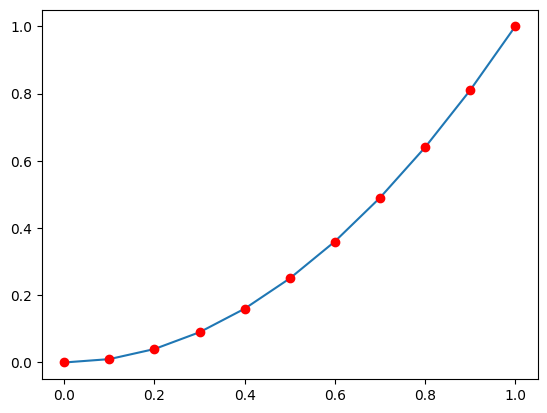

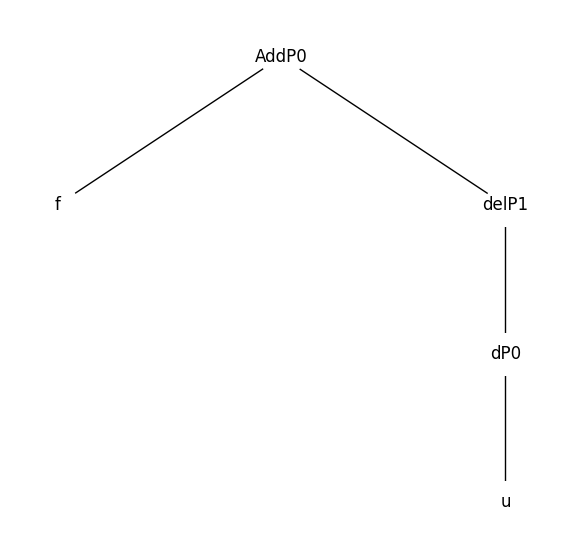

In [5]:

stgp_poisson()
